# Correlation

For the correlation analysis, we use the following structure:
1. Combine all data sources
2. Filtering
3. Aggregated sentiment by stock and time
4. Correlation analysis
5. Correlation plot

## Combine all data sources

In [2]:
# Packages
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#First get sentiment data, then stock data, and time aswell form original cleaned csv.
df_sentiment = pd.read_csv('cleaned_unlabeled_with_sentiment.csv')[['text_cleaned', 'sentiment']]
df_time = pd.read_csv('cleaned_unlabeled.csv')[['created']]
df_ticker = pd.read_csv('company_mentions.csv')['mentioned_companies']

#Now we combine the dataframes
df = pd.concat([df_sentiment, df_time, df_ticker], axis=1)
df


,text_cleaned,sentiment,created,mentioned_companies
0,its not about the money its about sending a me...,positive,1.611863e+09,NaN
1,math professor scott steiner says the numbers ...,neutral,1.611862e+09,GME
2,exit the system the ceo of nasdaq pushed to ha...,neutral,1.611862e+09,GME
3,new sec filing for gme! can someone less retar...,neutral,1.611862e+09,GME
4,not to distract from gme just thought our amc ...,neutral,1.611862e+09,"GME,AMC"
...,...,...,...,...
51211,what i learned investigating sava fud spreader...,neutral,1.627906e+09,NaN
51212,daily popular tickers thread for august 02 202...,neutral,1.627906e+09,"GME,AMD"
51213,hitler reacts to the market being irrational,negative,1.627902e+09,NaN
51214,daily discussion thread for august 02 2021 you...,neutral,1.627898e+09,NaN


## Filtering
Before anything is possible, we first need to filter for rows where mentioned_companies contains exactly one company

In [4]:
# First, remove any rows where mentioned_companies is NaN
df_single = df.dropna(subset=['mentioned_companies'])

# Then filter for rows where there's exactly one company
df_single = df_single[~df_single['mentioned_companies'].str.contains(',')]

# Statistics
print("Original number of rows:", len(df))
print("Number of rows with single company:", len(df_single))

# Distribution of companies
print("\nMost common companies:")
print(df_single['mentioned_companies'].value_counts().head(10))

Original number of rows: 51216
Number of rows with single company: 16720

Most common companies:
mentioned_companies
GME     8706
HOOD    2580
AMC     1775
BB       669
PLTR     590
TSLA     468
AMZN     224
SPCE     211
SNDL     211
AAPL     180
Name: count, dtype: int64


In [5]:
# Define the companies we want to keep (top 10)
companies_to_keep = ['GME', 'AMC', 'BB', 'TSLA', 'PLTR', 'AMZN', 'AAPL', 'SNDL', 'F', 'AMD']

# Filter df_single to only include those companies
df_final = df_single[df_single['mentioned_companies'].isin(companies_to_keep)]

# Display info about the filtering
print("Number of rows in df_single:", len(df_single))
print("Number of rows in df_final:", len(df_final))

# Show distribution of companies in final dataset
print("\nDistribution of companies in final dataset:")
print(df_final['mentioned_companies'].value_counts())


Number of rows in df_single: 16720
Number of rows in df_final: 13121

Distribution of companies in final dataset:
mentioned_companies
GME     8706
AMC     1775
BB       669
PLTR     590
TSLA     468
AMZN     224
SNDL     211
AAPL     180
AMD      155
F        143
Name: count, dtype: int64


## Aggregated sentiment by stock and time
Using top 10 companies, we aggregate sentiment daily for each company, and display the results in a plot.

/var/folders/lr/5_mcmq7n3w18x7gzmwwgk5740000gn/T/ipykernel_75426/34690486.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['sentiment_score'] = df_final['sentiment'].map(sentiment_map)
/var/folders/lr/5_mcmq7n3w18x7gzmwwgk5740000gn/T/ipykernel_75426/34690486.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['datetime'] = pd.to_datetime(df_final['created'], unit='s')
/var/folders/lr/5_mcmq7n3w18x7gzmwwgk5740000gn/T/ipykernel_75426/34690486.py:7: SettingWithCopyWarning: 
A value is tryi

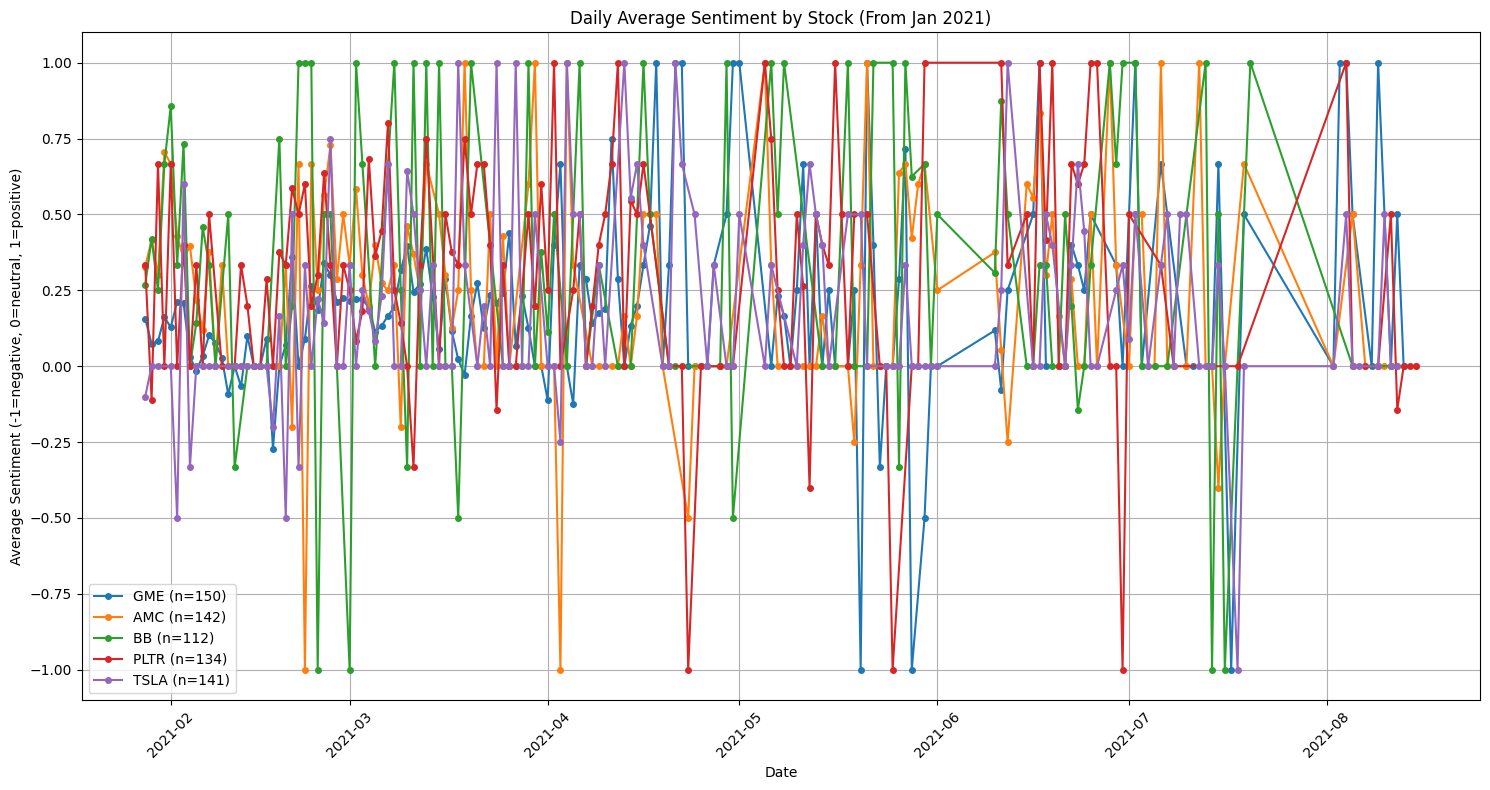


Summary Statistics for Top Stocks (From Jan 2021):
                    sentiment_score              text_cleaned
                               mean    std count        count
mentioned_companies                                          
AMC                           0.335  0.689  1775         1775
BB                            0.332  0.762   669          669
GME                           0.127  0.681  8706         8706
PLTR                          0.325  0.635   590          590
TSLA                          0.201  0.522   467          467


In [6]:
# Convert sentiment to numeric values
sentiment_map = {'negative': -1, 'neutral': 0, 'positive': 1}
df_final['sentiment_score'] = df_final['sentiment'].map(sentiment_map)

# Convert Unix to datetime and filter for dates after Jan 1, 2021
df_final['datetime'] = pd.to_datetime(df_final['created'], unit='s')
df_final['date'] = df_final['datetime'].dt.date
df_final = df_final[df_final['datetime'] >= '2021-01-01']

# Daily aggregation
daily_sentiment = df_final.groupby(['date', 'mentioned_companies']).agg({
    'sentiment_score': ['mean', 'count'],  # mean sentiment and number of posts
    'text_cleaned': 'count'  # number of mentions
}).reset_index()

# Flatten column names
daily_sentiment.columns = ['date', 'ticker', 'sentiment_mean', 'sentiment_count', 'mentions']

# Plot for the top N most discussed stocks
top_n = 5
top_stocks = df_final['mentioned_companies'].value_counts().head(top_n).index

# Create plot
plt.figure(figsize=(15, 8))

for ticker in top_stocks:
    stock_data = daily_sentiment[daily_sentiment['ticker'] == ticker]
    plt.plot(stock_data['date'], stock_data['sentiment_mean'], 
             label=f"{ticker} (n={len(stock_data)})", 
             marker='o', markersize=4)

plt.title('Daily Average Sentiment by Stock (From Jan 2021)')
plt.xlabel('Date')
plt.ylabel('Average Sentiment (-1=negative, 0=neutral, 1=positive)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics for Top Stocks (From Jan 2021):")
summary_stats = df_final[df_final['mentioned_companies'].isin(top_stocks)].groupby('mentioned_companies').agg({
    'sentiment_score': ['mean', 'std', 'count'],
    'text_cleaned': 'count'
}).round(3)

print(summary_stats)

## Correlation analysis
Now we can set up pairwise correlation between sentiment and daily stock returns. First we have to set up the dataframes with columns for sentment, and daily return.

In [7]:
Read stock data, and filter for dates after Jan 1, 2021
df_stock = pd.read_csv('stock_prices.csv')
df_stock = df_stock[df_stock['Date'] >= '2021-01-01']
df_stock


,Date,GME,AMC,BB,TSLA,PLTR,AMZN,AAPL,SNDL,F,AMD
85,2021-01-04,4.312500,20.100000,6.58,243.256668,23.370001,159.331497,126.544228,5.50,6.943574,92.300003
86,2021-01-05,4.342500,19.799999,6.77,245.036667,24.600000,160.925507,128.108765,5.40,7.049520,92.769997
87,2021-01-06,4.590000,20.100000,6.71,251.993332,23.540001,156.919006,123.796448,6.05,7.204366,90.330002
88,2021-01-07,4.520000,20.500000,7.06,272.013336,25.000000,158.108002,128.020752,6.85,7.383659,95.160004
89,2021-01-08,4.422500,21.400000,7.56,293.339996,25.200001,159.134995,129.125748,6.82,7.334761,94.580002
...,...,...,...,...,...,...,...,...,...,...,...
247,2021-08-25,49.912498,439.600006,10.74,237.066666,24.350000,164.959000,145.756210,7.76,10.733199,108.300003
248,2021-08-26,51.305000,403.100006,10.81,233.720001,24.870001,165.800003,144.950607,7.40,10.513157,107.269997
249,2021-08-27,51.237499,408.399994,11.30,237.306671,25.709999,167.481506,145.991989,7.62,10.847296,111.400002
250,2021-08-30,52.299999,433.299988,11.21,243.636673,25.760000,171.078506,150.432648,7.47,10.635404,111.320000


Let's add sentiment data to the stock dataframes.

In [8]:
# Convert dates to datetime
df_stock['Date'] = pd.to_datetime(df_stock['Date'])
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

# Create a copy
df_combined = df_stock.copy()

# Get list of tickers from df_stock columns (excluding 'Date')
stocks_tickers = [col for col in df_stock.columns if col != 'Date']

# Add sentiment data for each stock
for ticker in stocks_tickers:
    # Get sentiment data for this ticker
    ticker_sentiment = daily_sentiment[daily_sentiment['ticker'] == ticker]  
    
    # Create sentiment column name
    sentiment_col = f'{ticker}_sentiment'
    
    # Merge with stock data
    df_combined = df_combined.merge(
        ticker_sentiment[['date', 'sentiment_mean']], 
        left_on='Date',
        right_on='date',
        how='left'
    )
    
    # Rename sentiment column and drop extra date column
    df_combined = df_combined.rename(columns={'sentiment_mean': sentiment_col})
    df_combined = df_combined.drop('date', axis=1)

# Show number of non-null values per column
print("\nNumber of non-null values per column:")
print(df_combined.count())


Number of non-null values per column:
Date              167
GME               167
AMC               167
BB                167
TSLA              167
PLTR              167
AMZN              167
AAPL              167
SNDL              167
F                 167
AMD               167
GME_sentiment     106
AMC_sentiment     104
BB_sentiment       85
TSLA_sentiment    108
PLTR_sentiment     97
AMZN_sentiment     83
AAPL_sentiment     74
SNDL_sentiment     38
F_sentiment        50
AMD_sentiment      63
dtype: int64


Let's finish it up by creating the dataframes with daily return and lagged return.

In [9]:
# Create individual dataframes for each stock (with daily return and lagged return)
for ticker in stocks_tickers:
    # Create dataframe name dynamically
    df_name = f'df_{ticker}'
    
    # First, create a complete price dataframe with all trading days
    df_prices = df_combined[['Date', ticker]].copy()
    
    # Calculate next day returns using the complete price series
    df_prices[f'{ticker}_next_day_return'] = (df_prices[ticker].shift(-1) - df_prices[ticker]) / df_prices[ticker]
    
    # Now create the final dataframe with sentiment
    sentiment_col = f'{ticker}_sentiment'
    globals()[df_name] = df_combined[['Date', ticker, sentiment_col]].copy()
    
    # Add daily return column (today's return)
    return_col = f'{ticker}_daily_return'
    df_current = globals()[df_name]
    globals()[df_name][return_col] = (df_current[ticker] - df_current[ticker].shift(1)) / df_current[ticker].shift(1)
    
    # Merge the pre-calculated next day returns
    globals()[df_name] = globals()[df_name].merge(
        df_prices[['Date', f'{ticker}_next_day_return']], 
        on='Date', 
        how='left'
    )
    
    # Remove rows where sentiment is NaN (do this after all calculations)
    globals()[df_name] = globals()[df_name].dropna(subset=[sentiment_col])

## Correlation Plot

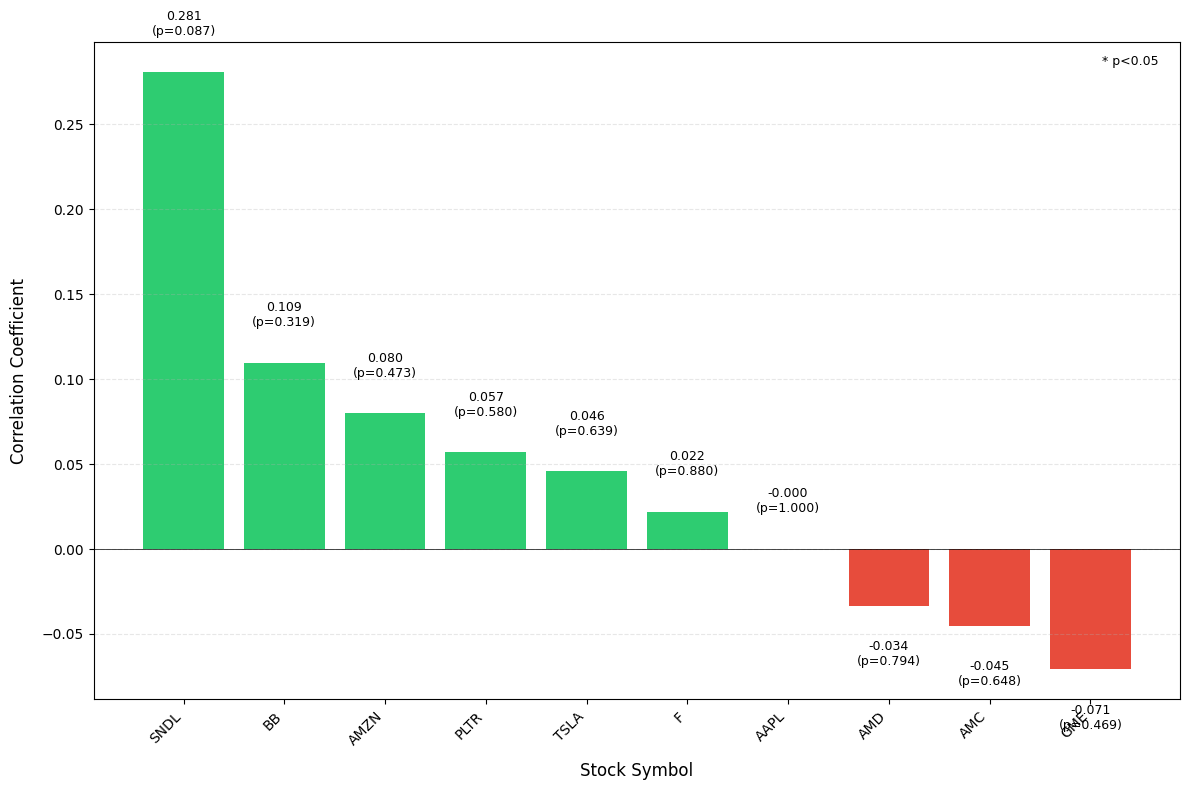


Correlation and P-values:
      Correlation  P-value
SNDL       0.2811   0.0874
BB         0.1094   0.3189
AMZN       0.0798   0.4732
PLTR       0.0569   0.5799
TSLA       0.0457   0.6386
F          0.0218   0.8805
AAPL      -0.0000   0.9999
AMD       -0.0336   0.7937
AMC       -0.0452   0.6484
GME       -0.0710   0.4695


In [12]:
import scipy.stats as stats

# Create dictionaries to store correlations and p-values
correlations = {}
p_values = {}

# Calculate correlations and p-values
for ticker in stocks_tickers:
    df = globals()[f'df_{ticker}']
    sentiment_col = f'{ticker}_sentiment'
    next_day_col = f'{ticker}_next_day_return'
    
    # Calculate correlation and p-value
    corr, p_val = stats.pearsonr(df[sentiment_col], df[next_day_col])
    correlations[ticker] = corr
    p_values[ticker] = p_val

# Convert to DataFrame
corr_df = pd.DataFrame({
    'Correlation': correlations,
    'P-value': p_values
}).round(4)
corr_df = corr_df.sort_values('Correlation', ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 8))

# Create bars
bars = plt.bar(corr_df.index, corr_df['Correlation'], 
               color=[('#2ecc71' if x >= 0 else '#e74c3c') for x in corr_df['Correlation']])

# Customize the plot
plt.title('', 
          fontsize=14, pad=15, fontweight='bold')
plt.xlabel('Stock Symbol', fontsize=12, labelpad=10)
plt.ylabel('Correlation Coefficient', fontsize=12, labelpad=10)

# Add gridlines
plt.grid(True, axis='y', linestyle='--', alpha=0.3)

# Customize
plt.xticks(rotation=45, ha='right')
plt.yticks(fontsize=10)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ticker = bar.get_x() + bar.get_width()/2.
    corr_val = corr_df.loc[corr_df.index[bars.index(bar)], 'Correlation']
    p_val = corr_df.loc[corr_df.index[bars.index(bar)], 'P-value']
    
    star = '*' if p_val < 0.05 else ''
    
    plt.text(ticker, 
             height + (0.02 if height >= 0 else -0.02),
             f'{corr_val:.3f}{star}\n(p={p_val:.3f})',
             ha='center', va='bottom' if height >= 0 else 'top',
             fontsize=9)

# Add legend for significance
plt.text(0.98, 0.98, 
         '* p<0.05', 
         transform=plt.gca().transAxes,
         ha='right', va='top',
         fontsize=9)

# Adjust layout and display
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

# Print the correlation and p-values table
print("\nCorrelation and P-values:")
print(corr_df)